In [1]:
import torch
import gc
from pathlib import Path
import os
import tqdm
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import random
from transformers import BertTokenizer, BertModel

/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
seq_len = 200
batch_size = 1
rand_tokens = torch.randint(100, 20000, (batch_size, seq_len))
eos_token = 102
tokenizer.bos_token_id = 102 
# try:
#     eos_token = tokenizer.bos_token_id
# except:
#     eos_token = 0

rep_tokens = torch.cat(
    [
        torch.zeros((batch_size, 1), dtype=torch.int64).fill_(eos_token),
        rand_tokens,
        rand_tokens,
    ],
    dim=1,
)

In [5]:
# txt = tokenized_dataset_for_reviews['train'][0][extraction_method]

# # Create input ids using encoder
# inputs = tokenizer(txt[0:100], return_tensors="pt", truncation=True, add_special_tokens=True)
# encoder_input_ids = inputs.input_ids

# Generate model outputs and decoder ids
model_outputs = model(rep_tokens)

In [6]:
attention = model_outputs[-1]

In [ ]:
# model_outputs.attentions

In [7]:
n_heads = 12
n_layers = 12

induction_score_store = torch.zeros(
    (n_heads, n_layers), dtype=torch.float32, device="cuda"
)

## BertViz

In [15]:
inputs = tokenizer.encode("The cat sat on the mat The cat sat on the mat", return_tensors='pt')
outputs = model(inputs)
attention = outputs[-1]  # Output includes attention weights when output_attentions=True
tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 

In [16]:
tokenizer.encode("[MASK]")

[101, 103, 102]

In [17]:
from bertviz import head_view
head_view(attention, tokens)

<IPython.core.display.Javascript object>

## Masking experimentation

In [18]:
# tutorial: https://huggingface.co/bert-base-uncased?text=Paris+is+the+%5BMASK%5D+of+France#limitations-and-bias

from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-uncased')
# unmasker("The man worked as a [MASK].")

/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
# tutorial: https://towardsdatascience.com/masked-language-modelling-with-bert-7d49793e5d2c

from transformers import BertTokenizer, BertForMaskedLM
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_masked = BertForMaskedLM.from_pretrained('bert-base-uncased', output_attentions=True)

text = ("After Abraham Lincoln won the November 1860 presidential "
        "election on an anti-slavery platform, an initial seven "
        "slave states declared their secession from the country "
        "to form the Confederacy. War broke out in April 1861 "
        "when secessionist forces attacked Fort Sumter in South "
        "Carolina, just over a month after Lincoln's "
        "inauguration.")

inputs = tokenizer(text, return_tensors='pt')
inputs['labels'] = inputs.input_ids.detach().clone()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
# create random array of floats in equal dimension to input_ids
rand = torch.rand(inputs.input_ids.shape)
# where the random array is less than 0.15 and token value is not 101 or 102, we set true
mask_arr = rand < 0.15 * (inputs.input_ids != 101) * (inputs.input_ids != 102)
selection = torch.flatten((mask_arr[0]).nonzero()).tolist()
inputs.input_ids[0, selection] = 103

In [32]:
inputs.input_ids.shape

torch.Size([1, 62])

In [21]:
outputs = model_masked(**inputs, )

In [ ]:
outputs.keys()

odict_keys(['loss', 'logits', 'attentions'])

In [23]:
outputs.attentions[0].shape

torch.Size([1, 12, 62, 62])

## RRT experiment with [MASK] token

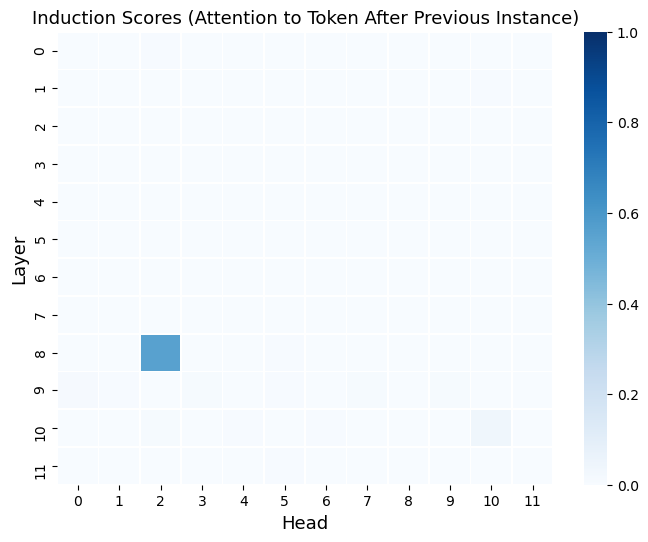

In [12]:
num_trials = 50
seq_len = 200
batch_size = 1
sep_token = 102 # [SEP] token id
induction_score_store = torch.zeros((n_heads, n_layers), dtype=torch.float32)

for i in range(num_trials):
    # generate random tokens
    rand_tokens = torch.randint(100, 20000, (batch_size, seq_len))
    # create RRT
    rep_tokens = torch.cat(
        [
            torch.zeros((batch_size, 1), dtype=torch.int64).fill_(sep_token),
            rand_tokens,
            rand_tokens,
        ],
        dim=1,
    )
    
    # Select random token to mask
    # Can run this later with masking array w/ several tokens
    rand_ind = random.randint(0, seq_len - 1)
    mask_ind = seq_len + rand_ind # + 1
    
    # old_token_id = int(rep_tokens[0][mask_ind])
    # old_token = ''.join(tokenizer.decode(rep_tokens[0][mask_ind]).split(" ")) # save old token
    rep_tokens[0][mask_ind] = 103 # replace token with [MASK]
        
    #output = model_masked(rep_tokens)
    output = model(rep_tokens)
    
    batch = 0
    for layer in range(12):
        for head in range(12):
            attn = output.attentions[layer][batch][head]
            mask_attn = attn[mask_ind]
            induction_score_store[layer][head] += (mask_attn[rand_ind + 1])

ind_scores_np = induction_score_store.detach().numpy() / num_trials
    
fig, ax = plt.subplots(figsize=(8, 6), dpi = 100)
norm = colors.TwoSlopeNorm(vmin=0, vcenter = 0.5, vmax=1)
s = sns.heatmap(ind_scores_np, fmt="",cmap='Blues',linewidths=0.50,ax=ax, norm = norm)
s.set_xlabel('Head', fontsize=13)
s.set_ylabel('Layer', fontsize=13)
plt.title('Induction Scores (Attention to Token After Previous Instance)', fontsize = 13)
plt.savefig('figs/ind_score_rrt_after.png', dpi = 150)

## RRT with no shuffling

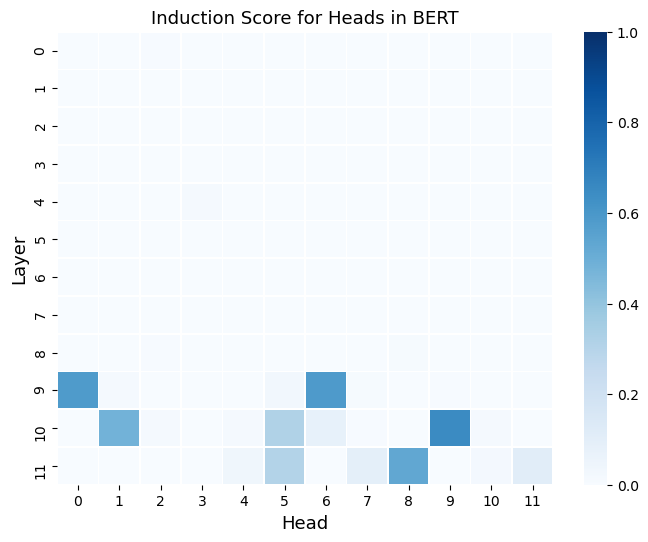

In [9]:
num_trials = 50
seq_len = 200
batch_size = 1
sep_token = 102 # [SEP] token id
induction_score_store = torch.zeros((n_heads, n_layers), dtype=torch.float32)

for i in range(num_trials):
    # generate random tokens
    rand_tokens = torch.randint(100, 20000, (batch_size, seq_len))
    # create RRT
    rep_tokens = torch.cat(
        [
            torch.zeros((batch_size, 1), dtype=torch.int64).fill_(sep_token),
            rand_tokens,
            rand_tokens,
        ],
        dim=1,
    )
    
    # Select random token to mask
    # Can run this later with masking array w/ several tokens
    rand_ind = random.randint(0, seq_len - 1)
    mask_ind = seq_len + rand_ind # + 1
    
    # old_token_id = int(rep_tokens[0][mask_ind])
    # old_token = ''.join(tokenizer.decode(rep_tokens[0][mask_ind]).split(" ")) # save old token
    rep_tokens[0][mask_ind] = 103 # replace token with [MASK]
        
    #output = model_masked(rep_tokens)
    output = model(rep_tokens)
    
    batch = 0
    for layer in range(12):
        for head in range(12):
            attn = output.attentions[layer][batch][head]
            mask_attn = attn[mask_ind]
            induction_score_store[layer][head] += (mask_attn[rand_ind])

ind_scores_np = induction_score_store.detach().numpy() / num_trials
    
fig, ax = plt.subplots(figsize=(8, 6), dpi = 100)
norm = colors.TwoSlopeNorm(vmin=0, vcenter = 0.5, vmax=1)
s = sns.heatmap(ind_scores_np, fmt="",cmap='Blues',linewidths=0.50,ax=ax, norm = norm)
s.set_xlabel('Head', fontsize=13)
s.set_ylabel('Layer', fontsize=13)
plt.title('Induction Score for Heads in BERT', fontsize = 13)
plt.savefig('figs/ind_score_rrt.png', dpi = 150)

## RRT with shuffling

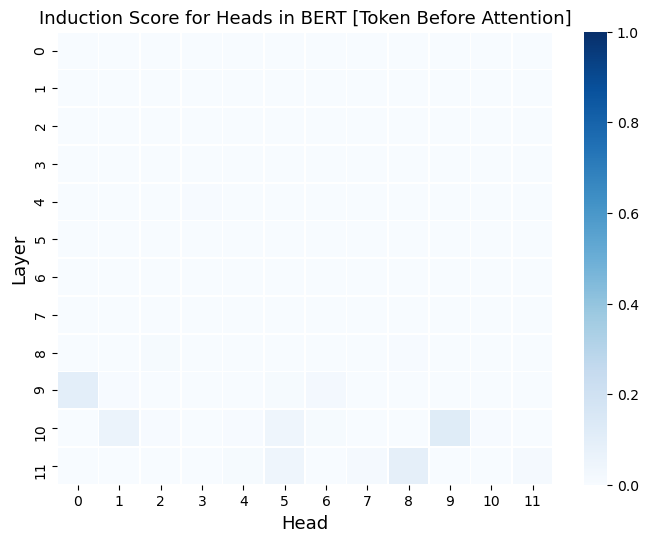

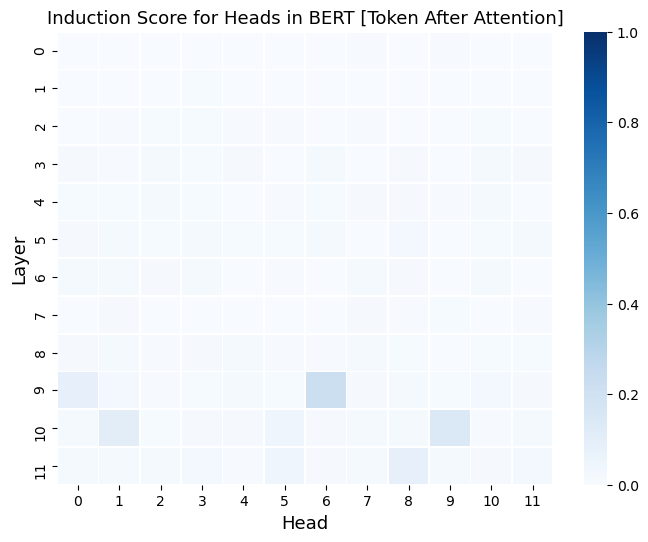

In [23]:
import random

num_trials = 50
seq_len = 200
batch_size = 1
sep_token = 102 # [SEP] token id
induction_score_store_before = torch.zeros((n_heads, n_layers), dtype=torch.float32)
induction_score_store_after = torch.zeros((n_heads, n_layers), dtype=torch.float32)


for i in range(num_trials):
    # generate random tokens
    rand_tokens = torch.randint(100, 20000, (batch_size, seq_len))
    # shuffle tokens
    idx = torch.randperm(rand_tokens.nelement())
    shuffled_tokens = rand_tokens.view(-1)[idx].view(rand_tokens.size())
    
    # create RRT
    rep_tokens = torch.cat(
        [
            torch.zeros((batch_size, 1), dtype=torch.int64).fill_(sep_token),
            rand_tokens,
            shuffled_tokens,
        ],
        dim=1,
    )
    
    # Select random token to mask
    # Can run this later with masking array w/ several tokens
    mask_ind = seq_len + random.randint(0, seq_len - 1) + 1
    old_token_id = int(rep_tokens[0][mask_ind])
    old_token = ''.join(tokenizer.decode(rep_tokens[0][mask_ind]).split(" ")) # save old token
    rep_tokens[0][mask_ind] = 103 # replace token with [MASK]
    
    t = rep_tokens[0]
    before2_ind = mask_ind - 1
    before2_token = int(t[mask_ind - 1])
    before1_ind = int((t == before2_token).nonzero(as_tuple=True)[0][0])
    # before1_token = t[before1_ind]
    attend_1 = before1_ind + 1

    after2_ind = mask_ind + 1
    after2_token = int(t[mask_ind + 1])
    after1_ind = int((t == after2_token).nonzero(as_tuple=True)[0][0])
    # after1_token = t[before1_ind]
    attend_2 = after1_ind - 1
    
    output = model(rep_tokens)
    
    batch = 0
    for layer in range(12):
        for head in range(12):
            attn = output.attentions[layer][batch][head]
            mask_attn = attn[mask_ind]
            avg = mask_attn.mean()
            std = mask_attn.std()
            # z_before = (mask_attn[before1_ind] - avg)/std
            # z_after = (mask_attn[after1_ind] - avg)/std
            # induction_score_store[layer][head] += (mask_attn[attend_1] + mask_attn[attend_2])
            induction_score_store_before[layer][head] += mask_attn[attend_1]
            induction_score_store_after[layer][head] += mask_attn[attend_2]

ind_scores_np = induction_score_store_before.detach().numpy() / num_trials
fig, ax = plt.subplots(figsize=(8, 6), dpi = 100)
norm = colors.TwoSlopeNorm(vmin=0, vcenter = 0.5, vmax=1)
s = sns.heatmap(ind_scores_np, fmt="",cmap='Blues',linewidths=0.50,ax=ax, norm = norm)
s.set_xlabel('Head', fontsize=13)
s.set_ylabel('Layer', fontsize=13)
plt.title('Induction Score for Heads in BERT [Token Before Attention]', fontsize = 13)
plt.savefig('figs/ind_score_shuffle_before.png', dpi = 150)

ind_scores_np = induction_score_store_after.detach().numpy() / num_trials
fig, ax = plt.subplots(figsize=(8, 6), dpi = 100)
norm = colors.TwoSlopeNorm(vmin=0, vcenter = 0.5, vmax=1)
s = sns.heatmap(ind_scores_np, fmt="",cmap='Blues',linewidths=0.50,ax=ax, norm = norm)
s.set_xlabel('Head', fontsize=13)
s.set_ylabel('Layer', fontsize=13)
plt.title('Induction Score for Heads in BERT [Token After Attention]', fontsize = 13)
plt.savefig('figs/induction_score_store_after.png', dpi = 150)

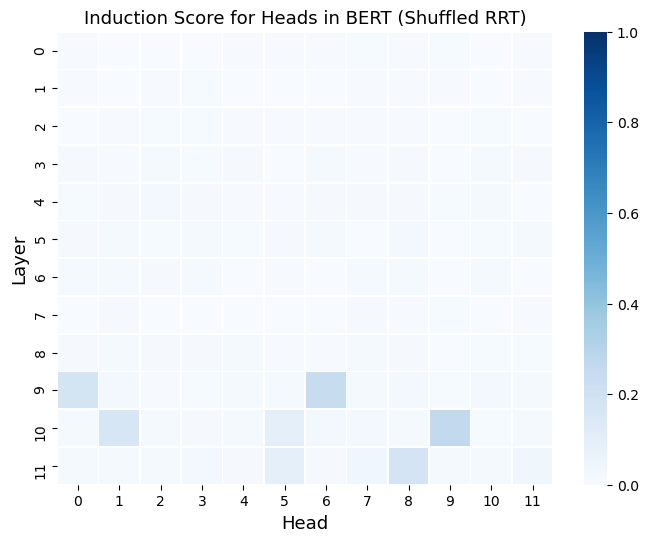

In [25]:
ind_scores_before_np = induction_score_store_before.detach().numpy() / num_trials
ind_scores_after_np = induction_score_store_after.detach().numpy() / num_trials
fig, ax = plt.subplots(figsize=(8, 6), dpi = 100)
norm = colors.TwoSlopeNorm(vmin=0, vcenter = 0.5, vmax=1)
s = sns.heatmap(ind_scores_before_np + ind_scores_after_np, fmt="",cmap='Blues',linewidths=0.50,ax=ax, norm = norm)
s.set_xlabel('Head', fontsize=13)
s.set_ylabel('Layer', fontsize=13)
plt.title('Induction Score for Heads in BERT (Shuffled RRT)', fontsize = 13)
plt.savefig('figs/induction_score_shuffle.png', dpi = 150)

## RRT w/ 3 repeated sequences

In [ ]:
num_trials = 50
seq_len = 200
batch_size = 1
sep_token = 102 # [SEP] token id
induction_score_store = torch.zeros((n_heads, n_layers), dtype=torch.float32)

for i in range(num_trials):
    # generate random tokens
    rand_tokens = torch.randint(100, 20000, (batch_size, seq_len))
    # create RRT
    rep_tokens = torch.cat(
        [
            torch.zeros((batch_size, 1), dtype=torch.int64).fill_(sep_token),
            rand_tokens,
            rand_tokens,
            rand_tokens
        ],
        dim=1,
    )
    
    # Select random token to mask
    # Can run this later with masking array w/ several tokens
    rand_ind = random.randint(0, seq_len - 1)
    mask_ind = seq_len + rand_ind + 1
    # old_token_id = int(rep_tokens[0][mask_ind])
    # old_token = ''.join(tokenizer.decode(rep_tokens[0][mask_ind]).split(" ")) # save old token
    rep_tokens[0][mask_ind] = 103 # replace token with [MASK]
        
    #output = model_masked(rep_tokens)
    output = model(rep_tokens)
    
    batch = 0
    for layer in range(12):
        for head in range(12):
            attn = output.attentions[layer][batch][head]
            mask_attn = attn[mask_ind]
            induction_score_store[layer][head] += (mask_attn[rand_ind])
            induction_score_store[layer][head] += (mask_attn[rand_ind])

ind_scores_np = induction_score_store.detach().numpy() / num_trials
    
fig, ax = plt.subplots(figsize=(8, 6), dpi = 100)
norm = colors.TwoSlopeNorm(vmin=0, vcenter = 0.5, vmax=1)
s = sns.heatmap(ind_scores_np, fmt="",cmap='Blues',linewidths=0.50,ax=ax, norm = norm)
s.set_xlabel('Head', fontsize=13)
s.set_ylabel('Layer', fontsize=13)
plt.title('Induction Score for Heads in BERT', fontsize = 13)
plt.savefig('figs/ind_score_triple.png', dpi = 150)